# 导入要使用的相关包

In [1]:
import collections
import os
import random
import tarfile
import time
import datetime
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data as Data
import torch.nn.functional as F
import torchtext
import torchtext.vocab as Vocab
import gensim
from gensim.models import word2vec as w2v
from gensim.models.word2vec import KeyedVectors
import jieba

from multiprocessing import Pool
import multiprocessing
import numpy as np
import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 测试使用设备
device

device(type='cuda')

In [2]:
def get_train_data(filename):
    df=pd.read_csv(filename)
    df=df.sample(frac=1)
    label=df.label
    review=df.review
    return label,review

l,r=get_train_data("文本分类语料.csv")

In [3]:
l.head(),r.head()

(2533    1
 8492    0
 1258    1
 545     1
 9164    0
 Name: label, dtype: int64,
 2533    比我想象的快啊，才一个多小时，这两天都是两三个小时的。
 8492                    等了好久好久好久。。。
 1258                   送的很快，味道不错，不咸
 545                送餐速度非常快，服务态度非常好。
 9164      大哥，你知道你送的这是披萨吗？拖成一坨让我怎么吃？
 Name: review, dtype: object)

In [4]:
r.apply(len).describe()

count    11987.000000
mean        25.048553
std         24.680028
min          5.000000
25%         11.000000
50%         17.000000
75%         30.000000
max        463.000000
Name: review, dtype: float64

In [5]:
r[r.apply(len)==463]

8544    这是儿童餐吗？饭和菜的量都少的可怜。米饭只有一小方块，装菜的格子本就不大，还只装到1/2的高...
Name: review, dtype: object

In [6]:
r.loc[8544]

'这是儿童餐吗？饭和菜的量都少的可怜。米饭只有一小方块，装菜的格子本就不大，还只装到1/2的高度其中还以菜汤为主，2个荤菜杏鲍菇肉片私自改成了窝笋肉片(实际上根本没有肉片只有三根肉丝)，所谓的奥尔良鸡排只是两片薄鸡片可怜巴巴的躺在格子底，I真是服了You!您这是20元的套餐？我当时真想拍下来传到网上让大家好好瞻仰学习一下，后来想想算了，毕竟这么多年也是你们的老客户了，给你们留点面子吧。不知道百度是怎么跟你们谈合作的，搞活动这13元是你们单独承担还是与百度分担，但无论如何菜品质量下降这么多是说不过去的，要是你们坚持说正品20元套餐就是这样的量，那恐怕活动后不会有人用原价买你们的正品了，那你们做这样的活动还有意义吗？这是专门要砸自己的招牌吗？,另外这款套餐的设计极不合理，你们16元的套餐是3荤2素米饭也比较多，20元的却是2荤2素1咸菜(这咸菜尤其鸡肋，又不是自己做的特色小菜只是普通的几根真空袋装的榨菜，既没营养又不健康而且没用——本来饭就少不用靠它下饭，被扔掉恐怕是绝大多数人的选择)饭极少，真不知道为什么还比前者贵。'

In [7]:
tqdm.pandas(desc='Jieba Processing')
review=r.progress_apply(lambda x:jieba.lcut(str(x)))

jieba processing:   0%|          | 0/11987 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.594 seconds.
Prefix dict has been built successfully.


In [8]:
def get_vocab():
    tokenized_data = review.to_list()
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    return torchtext.vocab.vocab(counter,min_freq=0)
vocab = get_vocab()

In [9]:
max_l = 100 #设置句子最大长度，不足补零

def func(listTemp, n):
    for i in range(0, len(listTemp), n):
        yield listTemp[i:i+n]
        
def pad(x):
    return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))

def wrap(lis):
    return [pad([vocab_dict.get(word) for word in words]) for words in tqdm(lis)]



vocab_dict=vocab.get_stoi()
vocab_list=review.to_list()
ret=list(func(vocab_list, int(len(vocab_list)/2)))
with Pool(2) as p:
    a=p.map(wrap,ret)

In [10]:
features=[]
for lis in a:
    features.extend(lis)
    
len(features)

11987

In [11]:
features = torch.tensor(features,device=device)

labels = torch.tensor(l.to_list(),device=device)

In [12]:
train_set_num=7
test_set_num=3

In [13]:
batch_size = 256
train_set_num=int(len(features)*train_set_num/10)

train_set = Data.TensorDataset(features[:train_set_num,],labels[:train_set_num])
train_iter = Data.DataLoader(train_set, batch_size)
test_set = Data.TensorDataset(features[train_set_num:,],labels[train_set_num:])
test_iter = Data.DataLoader(test_set, batch_size)


In [14]:
next(iter(train_iter))

[tensor([[   0,    1,    2,  ...,    0,    0,    0],
         [  16,   17,   18,  ...,    0,    0,    0],
         [  20,    3,   21,  ...,    0,    0,    0],
         ...,
         [ 770,   12, 1174,  ...,    0,    0,    0],
         [ 526,   65,  442,  ...,    0,    0,    0],
         [  23,   43, 1181,  ...,    0,    0,    0]], device='cuda:0'),
 tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
         1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
 

In [15]:
new_dict1 = dict(zip(vocab_dict.values(), vocab_dict.keys()))

for i in range(5):
    sen=""
    for token in next(iter(train_iter))[0][i].tolist():

        if(token!=0):
            sen+=new_dict1.get(token)

    print(f"{i}: "+sen)

0: 我想象的快啊，才一个多小时，这两天都是两三个小时的。
1: 等了好久好久好久。。。
2: 送的很快，味道不错，不咸
3: 送餐速度非常快，服务态度非常好。
4: 大哥，你知道你送的这是披萨吗？拖成一坨让我怎么吃？


In [16]:
nowtime = datetime.datetime.now()
model = KeyedVectors.load_word2vec_format("sgns.renmin.word", binary=False)
readtime = datetime.datetime.now()
print(f"模型加载耗时：{str(readtime-nowtime)[:-3]} s")

模型加载耗时：0:00:42.95 s


In [17]:
class GlobalMaxPool1d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool1d, self).__init__()
    def forward(self, x):
        return F.max_pool1d(x, kernel_size=x.shape[2])


In [18]:
class TextCNN(nn.Module):     
    def __init__(self, vocab, embed_size, kernel_sizes, num_channels):
        super(TextCNN, self).__init__()        
        
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # 不参与训练的嵌⼊层        
        self.constant_embedding = nn.Embedding(len(vocab), embed_size)   
        
        # 创建多个⼀维卷积层  
        self.convs = nn.ModuleList() 
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(in_channels = 2*embed_size, out_channels = c, kernel_size = k))
        
        # 时序最⼤池化层没有权重，所以可以共⽤⼀个实例
        self.pool = GlobalMaxPool1d() 
        
        self.dropout = nn.Dropout(0.5)
        
        self.decoder = nn.Linear(sum(num_channels), 2)
        
        
    def forward(self, inputs):
        # 将两个形状是(批量⼤⼩, 词数, 词向量维度)的嵌⼊层的输出按词向量连结
        embeddings = torch.cat((self.embedding(inputs),self.constant_embedding(inputs)), dim=2) # (batch, seq_len, 2*embed_size)    
       
        # 根据Conv1D要求的输⼊格式，将词向量维，即⼀维卷积层的通道维(即词向量那⼀维)，变换到前⼀维
        embeddings = embeddings.permute(0, 2, 1)
        
        # 对于每个⼀维卷积层，在时序最⼤池化后会得到⼀个形状为(批量⼤⼩, 通道⼤⼩, 1)的Tensor
        # 使⽤flatten函数去掉最后⼀维，然后在通道维上连结
        encoding = torch.cat([self.pool(F.relu(conv(embeddings))).squeeze(-1) for conv in self.convs], dim=1)
        
        # 应⽤丢弃法后使⽤全连接层得到输出
        outputs = self.decoder(self.dropout(encoding))
        return outputs


In [49]:
embed_size,  kernel_sizes, nums_channels = 300, [3, 4, 5], [300, 300, 300] 
net = TextCNN(vocab, embed_size, kernel_sizes, nums_channels).to(device=device)

In [50]:
def load_pretrained_embedding(words):
    """从预训练好的vocab中提取出words对应的词向量"""
    
    embed = torch.zeros(len(words),300) # 初始化为0
    oov_count = 0 # out of vocabulary
    for i, word in tqdm(enumerate(words),total=(len(words))):
        try:
            embed[i, :] = torch.from_numpy(model[word])
        except KeyError:
            oov_count += 1
    if oov_count > 0:
        print("There are %d oov words."%oov_count)
    return embed

net.embedding.weight.data.copy_(load_pretrained_embedding(vocab.get_stoi()))
net.constant_embedding.weight.data.copy_(load_pretrained_embedding(vocab.get_stoi()))
net.constant_embedding.weight.requires_grad = False


  0%|          | 0/11008 [00:00<?, ?it/s]

There are 3482 oov words.


  0%|          | 0/11008 [00:00<?, ?it/s]

There are 3482 oov words.


In [32]:
# 评价函数
def evaluate_accuracy(data_iter, net, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式， 会关闭dropout
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
                net.train() # 改回训练模式
            else:
                if ('is_training' in net.__code__.co_varnames):
                    # 如果有is_training这个参数将is_training设置成False
                    acc_sum += (net(X, is_training = False).argmax(dim=1) == y).float().sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n


In [47]:
train_acc_array=[]
test_acc_array=[]
loss_array=[]

In [23]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    epochs=tqdm(range(num_epochs))
    for i,epoch in enumerate(epochs):
        epochs.set_description("Total")
        
        train_acc_sum, sum_l, start, n, batch_count = 0.0, 0.0, time.time(), 0, 0
        pbar=tqdm(train_iter,desc="training")
        for X, y in pbar:
            out = net(X)
            l = loss(out,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            sum_l += l.item()
            n += y.shape[0]
            batch_count += 1
            train_acc_sum += (out.argmax(dim=1) == y).float().sum().item()
            
            
        test_acc = evaluate_accuracy(test_iter, net)
        train_acc_array.append(train_acc_sum / n)
        test_acc_array.append(test_acc)
        loss_array.append(sum_l / batch_count)
        
        print('epoch %d, loss %.4f, train_acc %.3f, test acc %.3f, time %.1f sec'
             % (epoch + 1, sum_l / batch_count, train_acc_sum / n, test_acc, time.time() - start ))

# 开始训练

In [29]:
net

TextCNN(
  (embedding): Embedding(11008, 300)
  (constant_embedding): Embedding(11008, 300)
  (convs): ModuleList(
    (0): Conv1d(600, 300, kernel_size=(3,), stride=(1,))
    (1): Conv1d(600, 300, kernel_size=(4,), stride=(1,))
    (2): Conv1d(600, 300, kernel_size=(5,), stride=(1,))
  )
  (pool): GlobalMaxPool1d()
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=900, out_features=2, bias=True)
)

  0%|          | 0/20 [00:00<?, ?it/s]

training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 1, loss 3.4910, train_acc 0.737, test acc 0.838, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 2, loss 0.4282, train_acc 0.872, test acc 0.869, time 3.8 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 3, loss 0.2150, train_acc 0.933, test acc 0.864, time 3.8 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 4, loss 0.1185, train_acc 0.959, test acc 0.868, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 5, loss 0.1028, train_acc 0.967, test acc 0.853, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 6, loss 0.1036, train_acc 0.967, test acc 0.856, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 7, loss 0.1680, train_acc 0.958, test acc 0.859, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 8, loss 0.1990, train_acc 0.957, test acc 0.853, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 9, loss 0.2532, train_acc 0.950, test acc 0.863, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 10, loss 0.2907, train_acc 0.953, test acc 0.849, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 11, loss 0.1779, train_acc 0.965, test acc 0.857, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 12, loss 0.0986, train_acc 0.977, test acc 0.864, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 13, loss 0.0938, train_acc 0.980, test acc 0.847, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 14, loss 0.0701, train_acc 0.979, test acc 0.860, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 15, loss 0.0573, train_acc 0.984, test acc 0.862, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 16, loss 0.0399, train_acc 0.987, test acc 0.867, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 17, loss 0.0578, train_acc 0.986, test acc 0.858, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 18, loss 0.0543, train_acc 0.987, test acc 0.866, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 19, loss 0.0564, train_acc 0.987, test acc 0.859, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 20, loss 0.0641, train_acc 0.986, test acc 0.859, time 4.0 sec


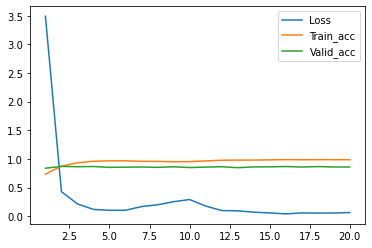

In [40]:
# Adam随即梯度下降 lr=0.01
lr, num_epochs = 0.01, 20
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)
torch.save(net, "model_small.pkl")

fig=plt.figure()
plt.plot(range(1,num_epochs+1),loss_array,label="Loss")
plt.plot(range(1,num_epochs+1),train_acc_array,label="Train_acc")
plt.plot(range(1,num_epochs+1),test_acc_array,label="Valid_acc")
plt.legend()
plt.savefig("Adam lr=0.01.png")

  0%|          | 0/20 [00:00<?, ?it/s]

training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 1, loss 0.6623, train_acc 0.608, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 2, loss 0.6238, train_acc 0.667, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 3, loss 0.6097, train_acc 0.667, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 4, loss 0.5975, train_acc 0.670, test acc 0.666, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 5, loss 0.5892, train_acc 0.677, test acc 0.672, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 6, loss 0.5786, train_acc 0.685, test acc 0.682, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 7, loss 0.5721, train_acc 0.695, test acc 0.692, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 8, loss 0.5662, train_acc 0.704, test acc 0.697, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 9, loss 0.5578, train_acc 0.713, test acc 0.708, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 10, loss 0.5517, train_acc 0.721, test acc 0.713, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 11, loss 0.5468, train_acc 0.727, test acc 0.719, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 12, loss 0.5403, train_acc 0.733, test acc 0.726, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 13, loss 0.5355, train_acc 0.737, test acc 0.731, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 14, loss 0.5309, train_acc 0.741, test acc 0.735, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 15, loss 0.5247, train_acc 0.747, test acc 0.739, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 16, loss 0.5218, train_acc 0.750, test acc 0.743, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 17, loss 0.5183, train_acc 0.753, test acc 0.745, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 18, loss 0.5150, train_acc 0.754, test acc 0.746, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 19, loss 0.5114, train_acc 0.754, test acc 0.750, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 20, loss 0.5073, train_acc 0.761, test acc 0.752, time 4.1 sec


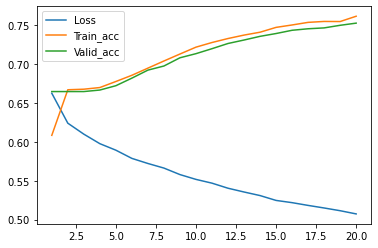

In [44]:
# 原文中的Adadelta lr=0.01
lr, num_epochs = 0.01, 20
optimizer = torch.optim.Adadelta(filter(lambda p:p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

fig=plt.figure()
plt.plot(range(1,num_epochs+1),loss_array,label="Loss")
plt.plot(range(1,num_epochs+1),train_acc_array,label="Train_acc")
plt.plot(range(1,num_epochs+1),test_acc_array,label="Valid_acc")
plt.legend()
plt.savefig("Adadelta lr=0.01.png")

  0%|          | 0/20 [00:00<?, ?it/s]

training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 1, loss 0.5740, train_acc 0.699, test acc 0.757, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 2, loss 0.4890, train_acc 0.773, test acc 0.772, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 3, loss 0.4545, train_acc 0.795, test acc 0.786, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 4, loss 0.4265, train_acc 0.812, test acc 0.797, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 5, loss 0.4005, train_acc 0.827, test acc 0.803, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 6, loss 0.3765, train_acc 0.842, test acc 0.810, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 7, loss 0.3542, train_acc 0.854, test acc 0.820, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 8, loss 0.3307, train_acc 0.870, test acc 0.832, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 9, loss 0.3076, train_acc 0.880, test acc 0.837, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 10, loss 0.2831, train_acc 0.892, test acc 0.843, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 11, loss 0.2631, train_acc 0.907, test acc 0.851, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 12, loss 0.2421, train_acc 0.914, test acc 0.859, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 13, loss 0.2214, train_acc 0.923, test acc 0.865, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 14, loss 0.2048, train_acc 0.931, test acc 0.870, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 15, loss 0.1873, train_acc 0.939, test acc 0.872, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 16, loss 0.1735, train_acc 0.946, test acc 0.876, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 17, loss 0.1620, train_acc 0.949, test acc 0.877, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 18, loss 0.1488, train_acc 0.955, test acc 0.879, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 19, loss 0.1376, train_acc 0.959, test acc 0.880, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 20, loss 0.1283, train_acc 0.963, test acc 0.883, time 4.0 sec


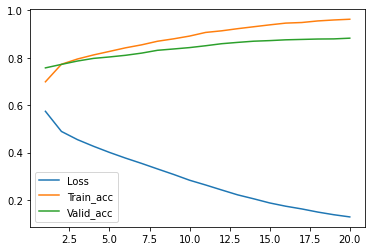

In [48]:
# Adam随即梯度下降 lr=0.0001
lr, num_epochs = 0.0001, 20
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)
torch.save(net, "model_small.pkl")

fig=plt.figure()
plt.plot(range(1,num_epochs+1),loss_array,label="Loss")
plt.plot(range(1,num_epochs+1),train_acc_array,label="Train_acc")
plt.plot(range(1,num_epochs+1),test_acc_array,label="Valid_acc")
plt.legend()
plt.savefig("Adam lr=0.0001.png")

In [51]:
# 原文中的Adadelta lr=0.0001
lr, num_epochs = 0.0001, 20
optimizer = torch.optim.Adadelta(filter(lambda p:p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 1, loss 0.6801, train_acc 0.577, test acc 0.656, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 2, loss 0.6779, train_acc 0.583, test acc 0.661, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 3, loss 0.6778, train_acc 0.583, test acc 0.663, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 4, loss 0.6731, train_acc 0.600, test acc 0.664, time 3.9 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 5, loss 0.6721, train_acc 0.603, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 6, loss 0.6707, train_acc 0.609, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 7, loss 0.6697, train_acc 0.617, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 8, loss 0.6661, train_acc 0.619, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 9, loss 0.6659, train_acc 0.625, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 10, loss 0.6644, train_acc 0.626, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 11, loss 0.6628, train_acc 0.630, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 12, loss 0.6611, train_acc 0.639, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 13, loss 0.6599, train_acc 0.638, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 14, loss 0.6601, train_acc 0.640, test acc 0.664, time 4.0 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 15, loss 0.6578, train_acc 0.646, test acc 0.664, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 16, loss 0.6561, train_acc 0.648, test acc 0.664, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 17, loss 0.6556, train_acc 0.646, test acc 0.664, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 18, loss 0.6553, train_acc 0.651, test acc 0.664, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 19, loss 0.6515, train_acc 0.657, test acc 0.664, time 4.1 sec


training:   0%|          | 0/33 [00:00<?, ?it/s]

epoch 20, loss 0.6517, train_acc 0.654, test acc 0.664, time 4.1 sec


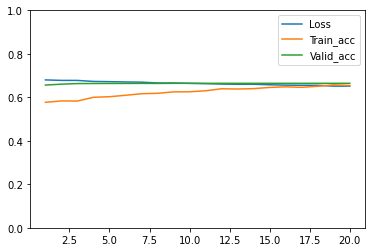

In [57]:
fig=plt.figure()
plt.ylim(0,1)
plt.plot(range(1,num_epochs+1),loss_array[20:],label="Loss")
plt.plot(range(1,num_epochs+1),train_acc_array[20:],label="Train_acc")
plt.plot(range(1,num_epochs+1),test_acc_array[20:],label="Valid_acc")
plt.legend()
plt.savefig("Adadelta lr=0.0001.png")

## -----------------参数--------------------

## 加载模型 

In [58]:
net=torch.load("model_small.pkl")

In [59]:
net

TextCNN(
  (embedding): Embedding(11008, 300)
  (constant_embedding): Embedding(11008, 300)
  (convs): ModuleList(
    (0): Conv1d(600, 300, kernel_size=(3,), stride=(1,))
    (1): Conv1d(600, 300, kernel_size=(4,), stride=(1,))
    (2): Conv1d(600, 300, kernel_size=(5,), stride=(1,))
  )
  (pool): GlobalMaxPool1d()
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=900, out_features=2, bias=True)
)

In [60]:
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())

embedding.weight : torch.Size([11008, 300])
constant_embedding.weight : torch.Size([11008, 300])
convs.0.weight : torch.Size([300, 600, 3])
convs.0.bias : torch.Size([300])
convs.1.weight : torch.Size([300, 600, 4])
convs.1.bias : torch.Size([300])
convs.2.weight : torch.Size([300, 600, 5])
convs.2.bias : torch.Size([300])
decoder.weight : torch.Size([2, 900])
decoder.bias : torch.Size([2])


In [61]:
model=net

Total_params = 0
Trainable_params = 0
NonTrainable_params = 0

for param in model.parameters():
    mulValue = np.prod(param.size())  # 使用numpy prod接口计算参数数组所有元素之积
    Total_params += mulValue  # 总参数量
    if param.requires_grad:
        Trainable_params += mulValue  # 可训练参数量
    else:
        NonTrainable_params += mulValue  # 非可训练参数量

print(f'Total params: {Total_params}')
print(f'Trainable params: {Trainable_params}')
print(f'Non-trainable params: {NonTrainable_params}')

Total params: 8767502
Trainable params: 5465102
Non-trainable params: 3302400


In [62]:
def predict():
    sentence=input("请输入测试句子：")
    if(sentence=="end"):
        return False
    sentence=jieba.lcut(sentence)
    sentence_vector= torch.tensor([pad([vocab.get_stoi().get(word) for word in sentence])]*batch_size,device=device)

    if isinstance(net, torch.nn.Module):
        # 评估模式， 会关闭dropout
        net.eval() 
        print(net(sentence_vector)[0])
        sm=torch.nn.Softmax(dim=1)
        print(sm(net(sentence_vector))[0])
        predict_label=net(sentence_vector).argmax(dim=1)[0]

        net.train() # 改回训练模式
        
        
        if predict_label==1:
            print("测试句子为正项\n")
            return True
            
        else:
            print("测试句子为负项\n")
            return True


In [63]:
lock=True
while(lock):
    try:
        lock=predict()
    except RuntimeError:
        print("词表中未含有该词！")
        lock=True

请输入测试句子：这家店真难吃，下次不来了
词表中未含有该词！
请输入测试句子：这家太难吃，下次不会来了
tensor([ 2.7921, -2.9442], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.9968, 0.0032], device='cuda:0', grad_fn=<SelectBackward0>)
测试句子为负项

请输入测试句子：这家店还不错哦，下次再来！
tensor([-1.6935,  1.5981], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0359, 0.9641], device='cuda:0', grad_fn=<SelectBackward0>)
测试句子为正项

请输入测试句子：感觉还不错呢！红烧茄子很好吃
tensor([-0.3666,  0.3784], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.3219, 0.6781], device='cuda:0', grad_fn=<SelectBackward0>)
测试句子为正项

请输入测试句子：end
